load data and create dataframes

In [1]:
import itertools
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
from pathlib import Path
from tqdm.notebook import tqdm
import os
import zipfile
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, random_split
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

random.seed(89034320423)

In [2]:
device_name = "cpu"  # default device is CPU
if torch.cuda.is_available():
    device_name = "cuda"  # CUDA for NVIDIA GPU
elif torch.backends.mps.is_available():
    device_name = torch.device("mps")  # Metal Performance Shaders for Apple M-series GPU
device = torch.device(device_name)
print(device_name)

mps


In [3]:
root_dir = './cifake'

# Using a list comprehension and generator expression
file_paths = [os.path.join(dirpath, filename) for dirpath, _, filenames in os.walk(root_dir) for filename in filenames]
labels = [os.path.basename(os.path.dirname(filepath)) for filepath in file_paths]

# Print the total number of file names and labels
print(len(file_paths), len(labels))

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_paths, "label": labels})
print(df.shape)
print(df.head())


120003 120003
(120003, 2)
                             image   label
0               ./cifake/.DS_Store  cifake
1          ./cifake/test/.DS_Store    test
2  ./cifake/test/REAL/0892 (2).jpg    REAL
3  ./cifake/test/REAL/0250 (5).jpg    REAL
4      ./cifake/test/REAL/0071.jpg    REAL


data transformations

In [4]:
from collections import Counter

# Compose your transformations
transform = v2.Compose([
    v2.RandomResizedCrop(size=(32,32), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


test_transform = v2.Compose([
    v2.RandomResizedCrop(size=(32,32), antialias=True),
    v2.ToTensor(),
])

dataset = ImageFolder(root=f"{root_dir}/train", transform=transform)
test_dataset = ImageFolder(root=f"{root_dir}/test", transform=test_transform)

train_size = int(0.8 * len(dataset)) #TODO change
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=True,num_workers=2)
test_loader= DataLoader(test_dataset, batch_size=100, shuffle=False,num_workers=2)

/Users/blake/miniforge3/envs/cs349/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [5]:
class EarlyStopper:
  def __init__(self, patience, min_delta):
      self.patience = patience
      self.min_delta = min_delta
      self.counter = 0
      self.min_validation_loss = float('inf')

  def early_stop(self, validation_loss):
      if validation_loss < self.min_validation_loss:
          self.min_validation_loss = validation_loss
          self.counter = 0
      elif validation_loss > (self.min_validation_loss + self.min_delta):
          self.counter += 1
          if self.counter >= self.patience:
              return True
      return False

In [6]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, batch_size):
        super(SimpleCNN, self).__init__()
        self.batch_size = batch_size
        
        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(512, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(self.batch_size, -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Epochs:


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss: 0.542699 

Validation accuracy: 0.703250 

Validation F1: 0.703250 

Validation mcc: 0.419935 



  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss: 0.526687 

Validation accuracy: 0.705100 

Validation F1: 0.705100 

Validation mcc: 0.431522 



  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss: 0.501747 

Validation accuracy: 0.734600 

Validation F1: 0.734600 

Validation mcc: 0.476564 



  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss: 0.490702 

Validation accuracy: 0.740300 

Validation F1: 0.740300 

Validation mcc: 0.491680 



  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss: 0.488073 

Validation accuracy: 0.738900 

Validation F1: 0.738900 

Validation mcc: 0.493729 

Evaluating on test set:


  0%|          | 0/200 [00:00<?, ?it/s]

Test accuracy: 0.54945
Test F1: 0.54945
Test MCC: 0.10103091107710965


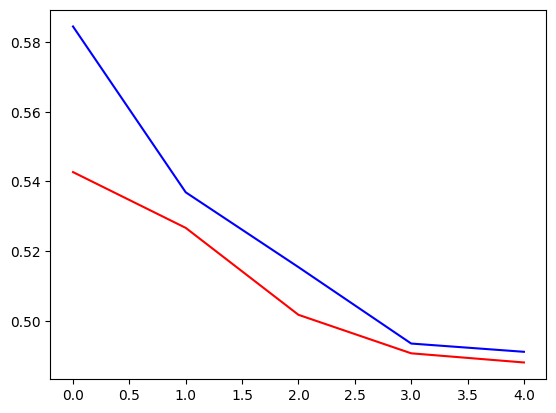

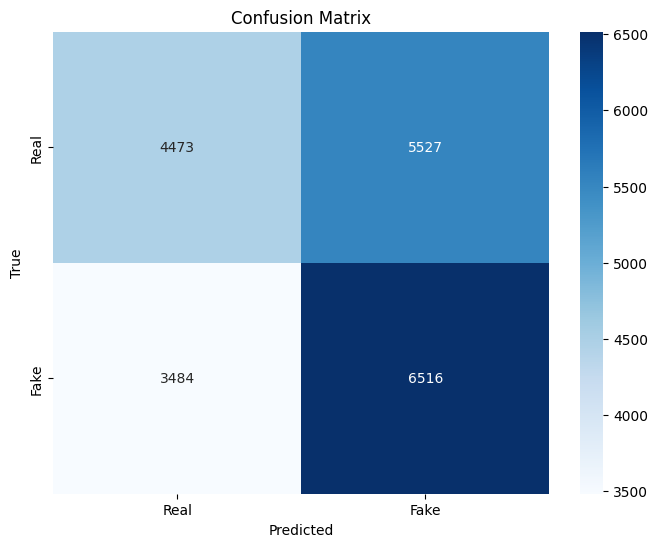

In [7]:
# Wrap your training loop with the Bottleneck profiler

def train(dataloader , model , loss_func, optimizer):

      model.train()
      train_loss = []

      for input, target in tqdm(dataloader):

          input, target = input.to(device), target.to(device)
          pred = model(input)
          pred = torch.squeeze(pred)
          loss = loss_func(pred, target.float())
          #backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_loss.append(loss.item())
      return train_loss

def validate(dataloader, model, loss_func, threshold=0.5):
    model.eval()
    
    num_batches = len(dataloader)
    test_loss= 0
    y_true = []
    y_pred = []

    with torch.no_grad():
      for input, target in tqdm(dataloader):
            input, target = input.to(device), target.to(device)
            pred = model(input)
            pred = torch.squeeze(pred)
            test_loss += loss_func(pred, target.float()).item()
            predicted = (pred >= threshold).float()
            y_true.extend(target.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
          
    test_loss /= num_batches
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="micro")
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"Validation loss: {test_loss:>8f} \n")
    print(f"Validation accuracy: {acc:>8f} \n")
    print(f"Validation F1: {f1:>8f} \n")
    print(f"Validation mcc: {mcc:>8f} \n")
    return test_loss


def test(dataloader, model, threshold=0.5):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        print("Evaluating on test set:")
        for input, target in tqdm(dataloader):
            input, target = input.to(device), target.to(device)
            pred = model(input)
            pred = torch.squeeze(pred)
            predicted = (pred >= threshold).float()
            y_true.extend(target.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return {
                "y_true": y_true,
                "y_pred": y_pred,
                "acc": accuracy_score(y_true, y_pred),
                "f1": f1_score(y_true, y_pred, average="micro"),
                "mcc": matthews_corrcoef(y_true, y_pred)
            }


def classify():
    early_stopper = EarlyStopper(patience=1, min_delta=0.01)
    
    input_size = 32*32
    output_size= 1 #isn't this supposed to be 2? for classifications (AI, Human)? #no it's 1 for binary classification
    ff = SimpleCNN(train_loader.batch_size).to(device)
    loss_fun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(ff.parameters(), lr = 1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    epochs = 5
    train_loss = []
    test_loss = []

    print("Epochs:")
    for t in tqdm(range(epochs)):
        losses = train(train_loader, ff, loss_fun, optimizer)
        train_loss.append(losses)
        validation_loss = validate(val_loader, ff, loss_fun)
        test_loss.append(validation_loss)
        if early_stopper.early_stop(validation_loss):
            print("early stop")
            break
        scheduler.step()

    plt.plot([i for i in range(len(train_loss))], torch.tensor(train_loss).mean(axis=1), color="blue") #training loss
    plt.plot([i for i in range(len(test_loss))], test_loss, color="red") #testing loss
    result = test(test_loader, ff)
    print(f"Test accuracy: {result['acc']}")
    print(f"Test F1: {result['f1']}")
    print(f"Test MCC: {result['mcc']}")

    conf_matrix = confusion_matrix(result["y_true"], result["y_pred"])

    # Plot confusion matrix
    labels = ['Real', 'Fake']
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    plt.show()
classify()